# AdaBoosting Algorithm implementation 🚀🚀🚀🚀

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import seaborn as sns
from sklearn import tree
from sklearn.metrics import roc_auc_score
sns.set()
#plt.style.use('classic')
%matplotlib inline

## Auxiliary functions

In [72]:
def ConfusionMatrix(df, var_target, var_score, cut_point):
    #Wang, Gang, et al. "A comparative assessment of ensemble learning for credit scoring." Expert systems with applications 38.1 (2011): 223-230.
    ### Target Variable must be in original domain, i.e, 1-default and 0-nonDefault
    
    
    df['Predito']=df[var_score].apply(lambda x: 1 if x>=cut_point else 0).values
    mtx_confusao = df[[var_target, 'Predito']].groupby(by=[var_target, 'Predito']).size()
    
    #Positive --> non RISK
    # Negativa --> RISK 
    TP = mtx_confusao[0][0] #non-default and classified as non-default
    FN = mtx_confusao[0][1] #non-default and classified as default
    FP = mtx_confusao[1][0] #default and classified as non-default
    TN = mtx_confusao[1][1] #default and classified as default
    
    print('TP: ',TP, '       FN: ' ,FN)
    print('FP: ',FP, '       TN: ' ,TN)
    print('-------------------------------')
    print('Type 1 Error(%):', np.round(100*(FN/(TP+FN)), 2))
    print('Type 2 Error(%):', np.round(100*(FP/(FP+TN)), 2))
    print('-------------------------------')
    print('Accuracy(%):', np.round(100*((TP+TN)/df.shape[0]),2))

In [2]:
def PlotDensity(df, target_variable, numerical_feature_variable, remove_extreme_values=False):
    fig, ax = plt.subplots(figsize=(10,8))

    df_aux = df[~df[numerical_feature_variable].isna()][[target_variable, numerical_feature_variable]].copy() #remove missing
    if remove_extreme_values == True:
        value_extreme = np.quantile(df_aux[numerical_feature_variable].values, 1-0.01) #remove extreme values, because these values may harm visualization
        df_aux = df_aux[df_aux[numerical_feature_variable]<value_extreme].copy() #remove extreme values, because these values may harm visualization
    
    df_aux_1 = df_aux[df_aux[target_variable] == 1].copy() # select default group
    df_aux_0 = df_aux[df_aux[target_variable] == 0].copy() # select non default group
    
    df_aux_1.columns = [target_variable, 'Default']
    df_aux_0.columns = [target_variable, 'NonDefault']
    
    sns.kdeplot(df_aux_1['Default'], shade=True, ax=ax) #display density
    sns.kdeplot(df_aux_0['NonDefault'], shade=True, ax=ax) #display density

In [3]:
def ks(df, target_variable, score_variable):
    
    n0_total = df[df[target_variable]==0].shape[0]
    n1_total = df[df[target_variable]==1].shape[0]
    ks_value=0
    for t in df[score_variable].values:
        df_ks = df[df[score_variable]<=t].copy()

        n0 = df_ks[df_ks[target_variable]==0].shape[0]
        n1 = df_ks[df_ks[target_variable]==1].shape[0]

        p0 = n0*1.0/n0_total
        p1 = n1*1.0/n1_total
        ks_aux = abs(p0-p1)

        if ks_aux>ks_value:
            ks_value = ks_aux
            
    return ks_value

## Ada Boosting

In [4]:
class AdaBoostingClassifier():
    def __init__(self, nEstimators, maxDepth):
        self.__lstAlphas = list()
        self.__lstBaseLearners = list()
        self.__nEstimators = nEstimators
        self.__maxDepth = maxDepth
    
    def predict_proba(self, df_X):
        lst_classifiers = self.__lstBaseLearners
        lst_alphas = self.__lstAlphas
        n_trees = self.__nEstimators

        for i in range(n_trees):
            tree_base = lst_classifiers[i]
            alpha = lst_alphas[i]

            if i==0:
                pdct = alpha*tree_base.predict(df_X)
            else:
                pdct = pdct + alpha*tree_base.predict(df_X)

        
        pdct = pdct/sum(np.array(lst_alphas))
        pdct = np.array([(x+1)/2 for x in pdct])
        return pdct
    
    def predict(self, df_X):
        lst_classifiers = self.__lstBaseLearners
        lst_alphas = self.__lstAlphas
        n_trees = self.__nEstimators

        for i in range(n_trees):
            tree_base = lst_classifiers[i]
            alpha = lst_alphas[i]

            if i==0:
                pdct = alpha*tree_base.predict(df_X)
            else:
                pdct = pdct + alpha*tree_base.predict(df_X)

        pdct = [1 if x>0 else -1 for x in pdct]
        return np.array(pdct)
    
    def fit_adaBoost(self, df, lst_predvars, var_target):
        lst_ensemble_classifiers = list()
        lst_ensemble_alpha = list()
        n_obs = df.shape[0]
        vec_weights = np.array([1/n_obs for x in range(n_obs)])
        
        vec_y_original = df[var_target].values
        for i in range(self.__nEstimators):
            #### Perform bootstrap sample ########
            
            df_aux = df.sample(frac=1, replace=True, weights=vec_weights)
            df_X = df_aux[lst_predvars].copy()
            vec_y = df_aux[var_target].values

            ###### Train base classifier ######
            tree_ensemble_aux = tree.DecisionTreeClassifier(criterion='entropy', max_depth=self.__maxDepth)
            tree_ensemble_aux_fit = tree_ensemble_aux.fit(df_X, vec_y)

            ###### update weights #######
            pdct_aux = tree_ensemble_aux_fit.predict(df[lst_predvars].copy())

            err = 0
            for j in range(len(vec_y_original)):
                if vec_y_original[j] != pdct_aux[j]:
                    err = err + vec_weights[j]
            #err = err/sum(vec_weights)

            #alpha = np.log10((1-err)/err)
            alpha = 0.5*np.log10((1/err) - 1)
            
            for j in range(len(vec_y_original)):
                if vec_y_original[j] != pdct_aux[j]:
                    vec_weights[j] = vec_weights[j]*np.exp(alpha)
                else:
                    vec_weights[j] = vec_weights[j]*np.exp(-alpha)
            
            vec_weights = vec_weights/sum(vec_weights)
            ### Store base classifiers ######
            lst_ensemble_classifiers.append(tree_ensemble_aux_fit)
            lst_ensemble_alpha.append(alpha)
            
        self.__lstAlphas = lst_ensemble_alpha
        self.__lstBaseLearners = lst_ensemble_classifiers
        

## Dataset Variables

In [5]:
target = 'SeriousDlqin2yrs'

lst_features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
                'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
                'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfDependents']

### Loading Data

In [6]:
df_dados = pd.read_csv('../GiveMeSomeCredit/cs-training.csv')
df_dados.drop(columns='Unnamed: 0', inplace=True)
df_dados.shape

(150000, 11)

In [7]:
# Using label -1 and 1 as described in reference [1]
## SeriousDlqin2yrs ===> 1 is default   -1 is non-default
df_dados['SeriousDlqin2yrs'] = df_dados['SeriousDlqin2yrs'].apply(lambda x: -1 if x==0 else x).values

In [8]:
df_dados

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,-1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,-1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,-1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,-1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,-1,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,-1,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,-1,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,-1,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


## Checking missing quantity

In [9]:
lst_missing_features = list()
for c in lst_features:
    nmiss = df_dados[df_dados[c].isna()].shape[0]
    if nmiss > 0:
        print('Variável: ', c, '  Nº missing: ', nmiss)
        lst_missing_features.append(c)

Variável:  MonthlyIncome   Nº missing:  29731
Variável:  NumberOfDependents   Nº missing:  3924


## Fill missing values using median

In [10]:
for c in lst_missing_features:
    vec_valores = df_dados[~df_dados[c].isna()][c].values
    valor = np.median(vec_valores)
    df_dados[c] = df_dados[c].fillna(valor).values

## Splitting Train and Test

In [11]:
df_test = df_dados.sample(frac=0.1, random_state=22111988, replace= False)
df_treino = df_dados.drop(index = df_test.index)

## Fitting Model

In [12]:
obj_adaBoost = AdaBoostingClassifier(nEstimators = 1000, maxDepth = 2)

In [13]:
obj_adaBoost.fit_adaBoost(df_treino, lst_features, target)

### Evaluating Model - Train dataset

In [14]:
pdct = obj_adaBoost.predict_proba(df_treino[lst_features])

In [15]:
print("Area Under Roc Curve", np.round(100*roc_auc_score(df_treino[target].values, pdct),2))

Area Under Roc Curve 86.41


###### Score density plot

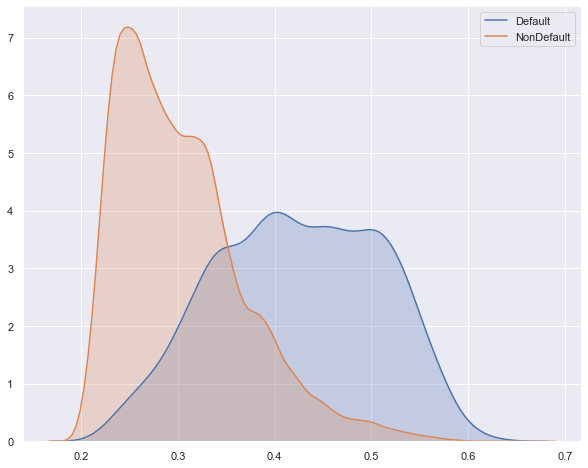

In [17]:
df_aux = pd.DataFrame(columns=[target, 'Score'])
df_aux[target] = df_treino[target].values
df_aux['Score'] = pdct

df_aux[target] = df_aux[target].apply(lambda x: 0 if x==-1 else x).values
PlotDensity(df_aux, target, 'Score')

In [76]:
ConfusionMatrix(df_aux, target, 'Score', 0.4)

TP:  114850        FN:  11163
FP:  3624        TN:  5363
-------------------------------
Type 1 Error(%): 8.86
Type 2 Error(%): 40.32
-------------------------------
Accuracy(%): 89.05


In [77]:
#print('KS Value is:', np.round(100*ks(df_aux, target, 'Score'),2))

### Evaluating Model - Test dataset

In [78]:
pdct = obj_adaBoost.predict_proba(df_test[lst_features])

In [79]:
print("Area Under Roc Curve", np.round(100*roc_auc_score(df_test[target].values, pdct),2))

Area Under Roc Curve 85.82


###### Score density plot

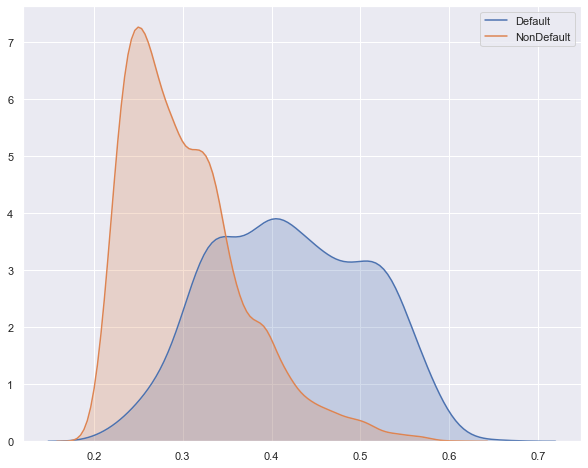

In [80]:
df_aux = pd.DataFrame(columns=[target, 'Score'])
df_aux[target] = df_test[target].values
df_aux['Score'] = pdct

df_aux[target] = df_aux[target].apply(lambda x: 0 if x==-1 else x).values
PlotDensity(df_aux, target, 'Score')

In [81]:
ConfusionMatrix(df_aux, target, 'Score', 0.4)

TP:  12708        FN:  1253
FP:  443        TN:  596
-------------------------------
Type 1 Error(%): 8.98
Type 2 Error(%): 42.64
-------------------------------
Accuracy(%): 88.69


In [21]:
#print('KS Value is:', np.round(100*ks(df_aux, target, 'Score'),2))

## Reference
* 1 - Shalev-Shwartz, S., Ben-David, S. (2014). Understanding Machine Learning: From Theory to Algorithms. Reino Unido: Cambridge University Press.
* 2 - Wang, Gang, et al. "A comparative assessment of ensemble learning for credit scoring." Expert systems with applications 38.1 (2011): 223-230.